# Quantized Neural Network 
## 01- Introduction to TFLite
by [Soon Yau Cheong](http://www.linkedin.com/in/soonyau)

For a starter, unlike Tensorflow(TF) that uses 32-bit floating point and run on desktop/server, Tensorflow Lite (TFlite) uses 8-bit integer and is designed to run on embedded devices and mobile phones with less powerful computational power. Quantization is a process to convert floating point into fixed-point integer and a converted network is therefore known as quantized neural network. 

In this tutorial, we will go through step-by-step on how to use TFLite to run inference and generate output from an image. We'll use a pre-trained MobileNet image trained on Imagenet dataset. Along the way, I'll introduce some fundamental concepts about TFLite.

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob

import utils
print("Tensorflow", tf.__version__)
print("Python", sys.version)

Tensorflow 1.10.0
Python 3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


## Download pre-trained TFlite model
Tensorflow lists some pre-trained quantized models on https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models.md that we can download. Let's select a Mobilenet v1 model which can take a few minutes to download.


In [2]:
url = "http://download.tensorflow.org/models/mobilenet_v1_2018_08_02/mobilenet_v1_1.0_224_quant.tgz"
dir_name = "models/mobilenet_v1"    
utils.maybe_download(dir_name, url)

models/mobilenet_v1/mobilenet_v1_1.0_224_quant.tgz
Download complete


## Files
Now let's look at the unzip files

In [3]:
fpaths = glob(dir_name+"/*")
file_sizes = [os.path.getsize(f)/2**20 for f in fpaths]
sort_indices = np.argsort(file_sizes)
for i in sort_indices:
    print("%s \t%.1f MB"%(fpaths[i].split('/')[-1], file_sizes[i]))

mobilenet_v1_1.0_224_quant_info.txt 	0.0 MB
mobilenet_v1_1.0_224_quant.ckpt.index 	0.0 MB
mobilenet_v1_1.0_224_quant_eval.pbtxt 	0.8 MB
mobilenet_v1_1.0_224_quant.tflite 	4.1 MB
mobilenet_v1_1.0_224_quant.ckpt.meta 	4.9 MB
mobilenet_v1_1.0_224_quant.ckpt.data-00000-of-00001 	16.2 MB
mobilenet_v1_1.0_224_quant_frozen.pb 	16.4 MB
mobilenet_v1_1.0_224_quant.tgz 	33.4 MB


Apart from the compressed .tgz that we've just downloaded, there are only two files related to TFlite which we will go through now. The rests are for full precision Tensorflow graph which we will defer until later tutorials. The first file \*_info.txt merely states basic information and name of input/output nodes. The TFlite model is stored in file extension .tflite and this is the file that we're interested in. We can already see that this file is much smaller about 4x smaller than the full precision frozen graph which is inline with reduction in memory going from 32-bit float to 8-bit integer.

In [4]:
utils.print_file(dir_name, 'mobilenet_v1_1.0_224_quant_info.txt')

Model: mobilenet_v1_1.0_224_quant

Input: input

Output: MobilenetV1/Predictions/Reshape_1



## Interpreter

First, let's load the model. Unlike Tensorflow graph that requires you to create a session, load the graph and variables, TFlite uses a call called interpreter that load entire graph and we can use it almost straight away.

In [5]:
model_name = 'mobilenet_v1_1.0_224_quant.tflite'
model_path = os.path.join(dir_name, model_name)
interpreter = tf.contrib.lite.Interpreter(model_path=model_path)
                                          
interpreter.allocate_tensors()


All retrievable information are stored as "tensor" e.g. input, activations, weights and biases. The operation information e.g. the operation layer and its attributes are not available. We could deduce the layer type from the tensor name but other information will need to be retrieved from the full Tensorflow graph. Now let's try to read the input tensors. 

In [6]:
input_details = interpreter.get_input_details()
input_details[0]

{'dtype': numpy.uint8,
 'index': 88,
 'name': 'input',
 'quantization': (0.0078125, 128),
 'shape': array([  1, 224, 224,   3], dtype=int32)}

From the input details, we can get see that it expect 8-bit unsigned integer (uint8). The tensor index can be used to read the actual tensor which is all zeros because we haven't actually set the input yet.(I'll talk about the 'quantization' in detailed in next tutorial.)

In [7]:
input_index = input_details[0]['index']
input_tensor = interpreter.get_tensor(input_index)

# print part of tensor
print(input_tensor[0,:,:,0])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


You can do the same for output by calling interpreter.get_output_details(). How about looking at the internal layers? Well, you can't ... at least not officially. I found out there is a internal function that can be used to get the tensor detail by index. However, there is no way to find out how many tensors are there, so I just started with some big numbers until the interpretor stop crashing.

In [8]:
num_layer = 89
for i in range(num_layer):
    detail = interpreter._get_tensor_details(i)
    print(i, detail['name'])

0 MobilenetV1/Logits/AvgPool_1a/AvgPool
1 MobilenetV1/Logits/Conv2d_1c_1x1/BiasAdd
2 MobilenetV1/Logits/Conv2d_1c_1x1/Conv2D_bias
3 MobilenetV1/Logits/Conv2d_1c_1x1/weights_quant/FakeQuantWithMinMaxVars
4 MobilenetV1/Logits/SpatialSqueeze
5 MobilenetV1/Logits/SpatialSqueeze_shape
6 MobilenetV1/MobilenetV1/Conv2d_0/Conv2D_Fold_bias
7 MobilenetV1/MobilenetV1/Conv2d_0/Relu6
8 MobilenetV1/MobilenetV1/Conv2d_0/weights_quant/FakeQuantWithMinMaxVars
9 MobilenetV1/MobilenetV1/Conv2d_10_depthwise/Relu6
10 MobilenetV1/MobilenetV1/Conv2d_10_depthwise/depthwise_Fold_bias
11 MobilenetV1/MobilenetV1/Conv2d_10_depthwise/weights_quant/FakeQuantWithMinMaxVars
12 MobilenetV1/MobilenetV1/Conv2d_10_pointwise/Conv2D_Fold_bias
13 MobilenetV1/MobilenetV1/Conv2d_10_pointwise/Relu6
14 MobilenetV1/MobilenetV1/Conv2d_10_pointwise/weights_quant/FakeQuantWithMinMaxVars
15 MobilenetV1/MobilenetV1/Conv2d_11_depthwise/Relu6
16 MobilenetV1/MobilenetV1/Conv2d_11_depthwise/depthwise_Fold_bias
17 MobilenetV1/MobilenetV1/

That is a long list!! No, the model doesn't actually have 89 layers. As mentioned earlier, the tensor includes everything like weight, bias etc. From the name, we can see that there are about 14 separable convolution layers. Also note that the layers are not arranged sequentially as the indices. Anyway, let's not worry about the details now. We'll now load an image and run it. 

## Inference
I have loaded a few sample images to try. Let's load one, reshape to the network input size, and display it.

In [35]:
print(os.listdir("images"))

['cat.jpg', 'red_fox.jpg', 'gold_fish.jpg']


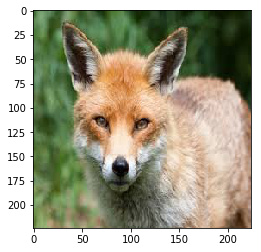

In [36]:
def load_image(img_path):
    
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))
    return img

img_path = "images/red_fox.jpg"
img = load_image(img_path)
plt.imshow(img)

Now format the input to match the network input dimension and double to check the shape and type.

In [10]:
input_image = np.array(img)
input_image = np.expand_dims(input_image, axis=0)
print("image shape:", input_image.shape)
print("image data type:", input_image.dtype)

image shape: (1, 224, 224, 3)
image data type: uint8


We're good to go. Now feed the image into the network's input tensor and read the output.

In [32]:
import time
input_details = interpreter.get_input_details()
input_index = input_details[0]['index']

start_time = time.time()

interpreter.set_tensor(input_index, input_image)
interpreter.invoke()


output_details = interpreter.get_output_details()
output_index = output_details[0]['index']
output_data = interpreter.get_tensor(output_index)

elapsed = time.time()-start_time
print("inference time: %.1f ms"%(1000*elapsed))

inference time: 86.0 ms


TFLite interpreter doens't use computer GPU and running on my laptop's CPU achieved 86ms inference time. The benchmark on Tensorflow page gives smaller number because those were tested on mobile phone. We should run testing on embedded devices later, perhaps on a Raspberry PI. 

If we nonw move our atention to the network output, the output is tensor with 1001 classes. Each value represent the likelihood of the image belong to that class. We can plot the value and pick the one with highest value as the predicted class.

(1, 1001)


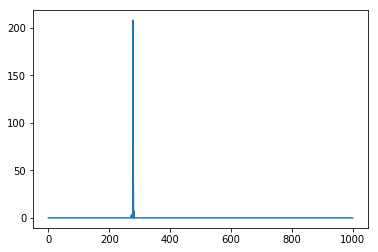

In [12]:
print(output_data.shape)
plt.plot(output_data[0,:])


Let's normalize the output so they sum to 1.0, and plot the top-3 predictions and confidence

In [28]:
confidence = output_data[0,:]/np.sum(output_data)

top3_idx = np.flip(np.argsort(confidence))[:3]
print("id", "    confidence\t", "class name")
for i in top3_idx:
    label_name = utils.imagenet_id_to_class(i)
    print(i,"\t%.1f%%\t"%(100*confidence[i]), label_name,)

id     confidence	 class name
278 	81.6%	 red fox, Vulpes vulpes
279 	12.9%	 kit fox, Vulpes macrotis
281 	2.7%	 grey fox, gray fox, Urocyon cinereoargenteus


# What's Next?
Now you have learned how to run pre-trained TFlite model. In next tutorial we will talk about what quantization really is and how to quantize a floating point graph into integer graph. Now, feel free to play with the code and try different images. 